<a href="https://colab.research.google.com/github/mostafa-ja/Machine-Learning-fall2023/blob/main/ML_presentation3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 98976120.55it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103800937.30it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27859024.50it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17921475.79it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [5]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [6]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.211000	0.629134	0.030700	0.099724
0.026017	0.084085	0.020000	0.064645
0.017500	0.055015	0.016800	0.051659
0.013083	0.040850	0.014900	0.046406
0.009383	0.030733	0.014600	0.046459
0.004933	0.015594	0.011500	0.035158
0.003333	0.011909	0.012000	0.035113
0.002983	0.010478	0.011600	0.036655
0.002333	0.009348	0.011400	0.036701
0.002083	0.008475	0.011700	0.038055


In [8]:
# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient tracking
        for inputs, labels in data_loader:
            inputs = inputs.to(device)  # Move inputs to GPU/CPU if available
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Assuming test_loader contains the test dataset
accuracy = calculate_accuracy(model_cnn, test_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.83%


In [58]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [10]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

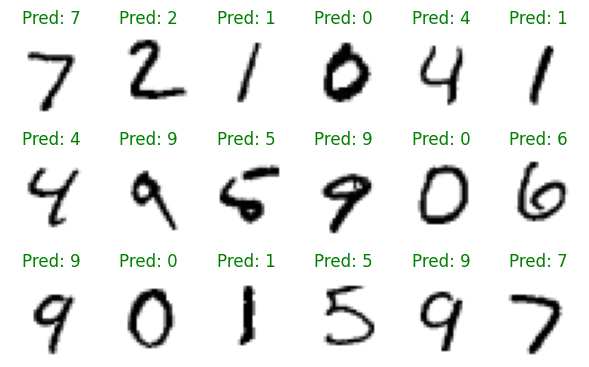

In [11]:
### Illustrate original predictions
yp = model_cnn(X)
plot_images(X, y, yp, 3, 6)

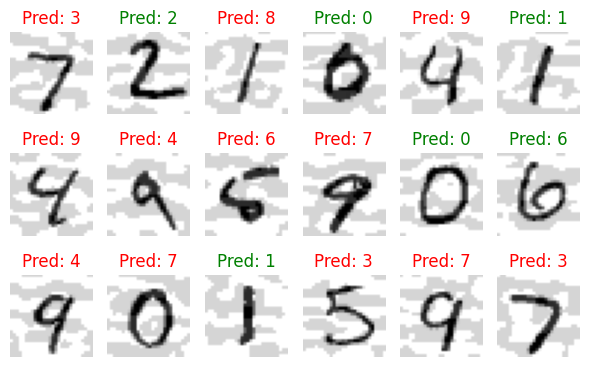

In [13]:
### Illustrate attacked images
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [50]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_correct = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)

        total_correct += (yp.max(dim=1)[1] == y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_correct / len(loader.dataset), total_loss / len(loader.dataset)

In [51]:
print("Accuracy on FGSM adversarial attack:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

Accuracy on FGSM adversarial attack: 0.5088


In [52]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

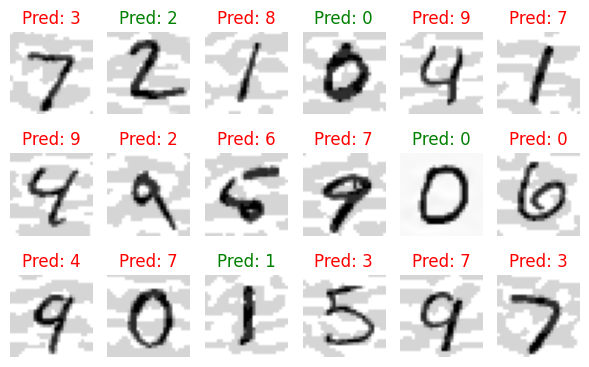

In [20]:
### Illustrate attacked images
delta = pgd(model_cnn, X, y, 0.1, 1e4, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [53]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

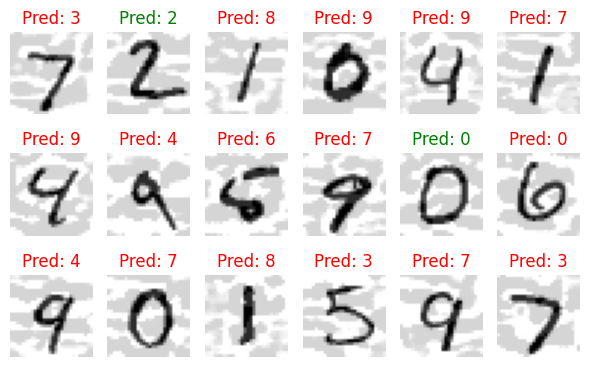

In [22]:
### Illustrate attacked images
delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [54]:
print("Accuracy on PGD adversarial attack:", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

Accuracy on PGD adversarial attack: 0.2098


In [30]:
def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)

    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon

        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()

        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    return max_delta

In [31]:
print("Accuracy on PGD adversarial attack(random start):", epoch_adversarial(model_cnn, test_loader, pgd_linf_rand, 0.1, 1e-2, 40, 10)[0])

Accuracy on PGD adversarial attack(random start): 0.19


In [32]:
def norms(Z):
    """Compute norms over all but the first dimension"""
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]


def pgd_l2(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)
        delta.grad.zero_()

    return delta.detach()

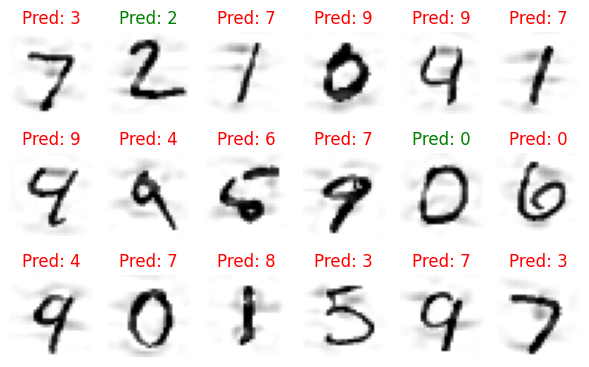

In [33]:
delta = pgd_l2(model_cnn, X, y, epsilon=2, alpha=0.1, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [56]:
pgd_attack_range = np.arange(0.0, 0.52, 0.025)
pgd_acc = []
for eps in pgd_attack_range:
    pgd_acc.append(epoch_adversarial(model_cnn, test_loader, pgd_linf, eps, 1e-2, 40)[0])

In [62]:
iter_fgsm_attack_range = np.arange(0.0, 0.52, 0.025)
iter_fgsm_acc = []
for eps in iter_fgsm_attack_range:
    iter_fgsm_acc.append(epoch_adversarial(model_cnn, test_loader, fgsm, eps)[0])

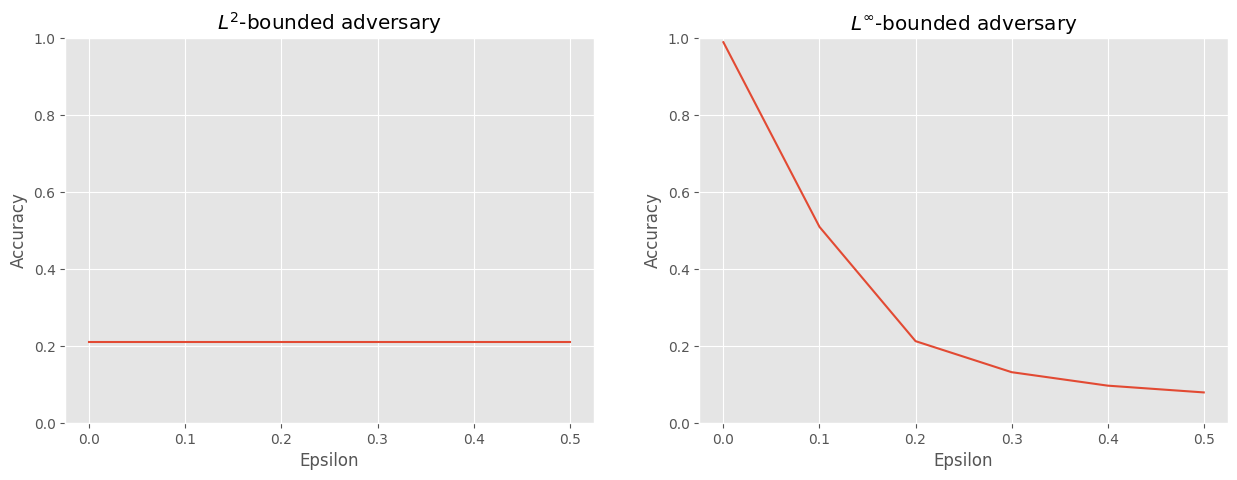

<Figure size 1400x700 with 0 Axes>

In [63]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))

    axes[0].set_title('$L^2$-bounded adversary')
    axes[0].plot(pgd_attack_range, pgd_acc)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epsilon')
    axes[0].set_ylim((0,1))

    axes[1].set_title('$L^{\infty}$-bounded adversary')
    axes[1].plot(iter_fgsm_attack_range, iter_fgsm_acc)
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epsilon')
    axes[1].set_ylim((0,1))

    plt.show()

#Adversarial training with adversarial examples

In [64]:
def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [65]:
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

In [66]:
def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_cnn_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

0.457900	0.025800	0.083100


In [ ]:
# Assuming test_loader contains the test dataset
accuracy = calculate_accuracy(model_cnn_robust, test_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Assuming test_loader contains the test dataset
accuracy =1 - epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40)[0]
print(f"Accuracy on PGD attack: {accuracy * 100:.2f}%")

In [ ]:
pgd_acc_linf = []
for eps in pgd_attack_range:
    pgd_acc_linf.append(epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

In [ ]:
iter_fgsm_acc_linf = []
for eps in iter_fgsm_attack_range:
    iter_fgsm_acc_linf.append(epoch_adversarial(model_cnn, test_loader, fgsm, eps)[0])

In [ ]:
with plt.style.context('ggplot'):

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))

    axes[0].set_title('$L^2$-bounded adversary')
    axes[0].plot(pgd_attack_range, pgd_acc, label='Natural')
    axes[0].plot(pgd_attack_range, pgd_acc_linf, label='$L{\infty}$ training')
#     axes[0].vlines([3], 0, 1, colors=COLOURS[1], linestyle='--')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epsilon')
    axes[0].set_ylim((0,1))
    axes[0].legend()

    axes[1].set_title('$L^{\infty}$-bounded adversary')
    axes[1].plot(iter_fgsm_attack_range, iter_fgsm_acc)
    axes[1].plot(iter_fgsm_attack_range, iter_fgsm_acc_linf, label='$L{\infty}$ training')
#     axes[1].vlines([0.3], 0, 1, colors=COLOURS[2], linestyle='--')
    axes[1].set_xlabel('Epsilon')
    axes[1].set_ylim((0,1))

    plt.show()